# DATA20001 Deep Learning - Exercise 3

**Due Tuesday November 21, before 12:00 PM (noon)**

In this second computer exercise we are going to work with images and convolutional neural networks, or CNNs. The entire exercise will be done using [Keras](https://keras.io/).

## Exercise 3.1. A simple CNN (2 points)

We'll start by showing you step by step how to create a simple CNN in Keras.  At some points you'll have to fill some code yourself. You can refer to the [Keras documentation](https://keras.io/) to find the right commands.

First, let's load all the needed libraries.

In [1]:
%matplotlib inline

from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
from keras.layers.convolutional import Conv2D

import exer3_dataset
from keras.utils import np_utils
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(123)

Using TensorFlow backend.


### Dataset

A key part of machine learning is always handling and preprocessing the dataset.  In this exercise we've made your life easier by having already prepared a dataset and split it into training and testing parts. 

Run the following command to download the dataset.  The first time you run this it will take while as it's pulling the data down over the network.

In [2]:
(x_train, y_train), (x_test, y_test) = exer3_dataset.load_data()

4120576/4422102 [==========================>...] - ETA: 0s

Let's see how the data is formatted by printing the dimensionalities of the variables (tensors).

In [3]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (60000, 28, 28, 1)
y_train (60000,)
x_test (10000, 28, 28, 1)
y_test (10000,)


Above you can see we have 60000 samples of 28x28 images in `x_train`. The third dimension of the images is just 1 as there is just a single grayscale value. The test set is formatted in the same way, except we have just 10000 samples.

The class labels are stored in `y_train`. Let's print the first 10 values just to see what they are...

In [4]:
print(y_train[:10])

[9 0 0 3 0 2 7 2 5 5]


These are the correct classes for each image.  These actually refer to different types of clothing.  Let's define the mapping from class indices to human-understandable labels as a Python dictionary. We have 10 classes, i.e., 10 categories of images to classify.

In [5]:
num_classes = 10

labels = {
  0: 'T-shirt/top',
  1: 'Trouser',
  2: 'Pullover',
  3: 'Dress',
  4: 'Coat',
  5: 'Sandal',
  6: 'Shirt',
  7: 'Sneaker',
  8: 'Bag',
  9: 'Ankle boot'
}

So, according to this the first image is of class 9, which is an "Ankle boot". Let's look at the first image.

In [6]:
img0=x_train[0,:,:].reshape(28,28)
print(img0)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 23

That's pretty hard to decipher. Let's instead draw it as an image, interpreting each number as a grayscale value.

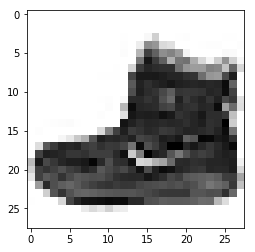

In [7]:
plt.imshow(img0, cmap='Greys', interpolation='none')

I suppose that's an ankle boot...

Typically we use so called one-hot encoding for the class labels in neural networks.  That is instead of having a single value which can have one of 10 label values (e.g. 0, ..., 9), we have 10 values which can each be 1 or 0 depending on if that class is present. 

Then for the output we typically expect something that looks like a probability distribution over these 10 classes, i.e., each neuron has a value between 0 and 1 indicating the probability of that class being present. For example if the tenth (last) neuron is 0.8, then we have 80% probability of the image containing an ankle boot. (The sum over all classes should also be 1.0 in order for it be a probability distribution.)

Here we'll call a utility function to transform the class labels into a one-hot encoding format.

In [8]:
print("Old format", y_train[:5])
y_train_cat = np_utils.to_categorical(y_train, num_classes)
y_test_cat = np_utils.to_categorical(y_test, num_classes)
print("One-hot encoding\n", y_train_cat[:5,])

Old format [9 0 0 3 0]
One-hot encoding
 [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


You can take a look at the output above. For example for the first image, which has label 9, the tenth value is 1, the rest are zero.

Let's display the first example image of each class just for fun.

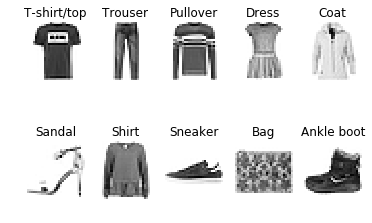

In [9]:
for l in range(10):
    idx = np.argwhere(y_train==l)[0]
  
    plt.subplot(2, 5, l+1)

    img = x_train[idx,:,:].reshape(28,28)

    plt.imshow(img, cmap='Greys', interpolation='none')
    plt.title(labels[l])
    plt.axis('off')

Finally, we normalize the images to be in the range 0.0 to 1.0 instead of 0 to 255.

In [10]:
x_train = x_train/255
x_test = x_test/255

### Create the network

OK, let's create a simple CNN that learns to detect these classes. 

<span style="background-color: yellow">Below you need to fill in the neural network layers</span>, which are (in order):

- One 2D convolutional layer with kernel size 3x3 and 32 output filters/features

- ReLU activation

- Max pooling (2D) of size 2x2

- Fully-connected (dense) layer to 10 output units (for the 10 classes)

- Finally softmax activation to get a probability-like output.

**Hint:** For the first layer you'll need to specify the shape of the input tensor manually by giving this parameter: `input_shape=(28, 28, 1)`.

Before the dense layer we need a `Flatten()` layer. This is a special layer in Keras that transforms the 2D output into 1D. The 2D convolution works with neurons in 2D, but the dense layer works in 1D.

In [12]:
# Initialize model
model = Sequential()

# Add layers here
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(10,activation='softmax'))

# Let's use categorical crossentry and sgd optmizer
model.compile(loss='categorical_crossentropy', 
              optimizer='sgd', 
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________
None


### Training

Now let's train it for 10 epochs. This takes roughly 5 minutes on a CPU.

We use a batch size of 128, which means that the weight updates are calculated for 128 inputs at a time.

In [13]:
%%time

epochs = 10 # one epoch typically takes a minute or two

history = model.fit(x_train, 
                    y_train_cat, 
                    epochs=epochs, 
                    batch_size=128,
                    verbose=1)

Epoch 1/10
60000/60000 [==============================] - 13s - loss: 1.0391 - acc: 0.6644    
Epoch 2/10
60000/60000 [==============================] - 12s - loss: 0.6088 - acc: 0.7871    
Epoch 3/10
60000/60000 [==============================] - 12s - loss: 0.5487 - acc: 0.8053    
Epoch 4/10
60000/60000 [==============================] - 12s - loss: 0.5244 - acc: 0.8131    
Epoch 5/10
60000/60000 [==============================] - 12s - loss: 0.5017 - acc: 0.8233    
Epoch 6/10
60000/60000 [==============================] - 13s - loss: 0.4883 - acc: 0.8278    
Epoch 7/10
60000/60000 [==============================] - 12s - loss: 0.4763 - acc: 0.8322    
Epoch 8/10
60000/60000 [==============================] - 12s - loss: 0.4636 - acc: 0.8374    
Epoch 9/10
60000/60000 [==============================] - 12s - loss: 0.4557 - acc: 0.8389    
Epoch 10/10
60000/60000 [==============================] - 12s - loss: 0.4486 - acc: 0.8438    
CPU times: user 5min 54s, sys: 1min 23s, total: 7

Let's plot how the loss and accuracy have changed over the training time.

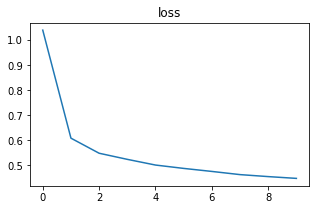

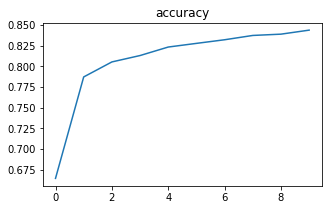

In [14]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'])
plt.title('accuracy')


### Inference

Next, let's how well the model can generalize to data it hasn't seen before, i.e., the test data. Recall from your basic machine learning that this is really the crucial part: it's trivial to learn to perfectly model the training set (you can just memorize each example), the hard part is to learn something general about the classes. So let's try to predict the labels of the test dataset, and compare to the correct labels.

In [15]:
scores = model.evaluate(x_test, y_test_cat, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 83.70%


You should get roughly 84% above if you have done exactly the same steps.  The real result can vary a lot on the random initialisation as we run only 10 epochs here.

### Visualise the weights

An interesting thing is to visualise the learned weights for the convolutional layer.  We have 32 kernels of size 3x3, we can just plot them as images, mapping the weight values to grayscale.

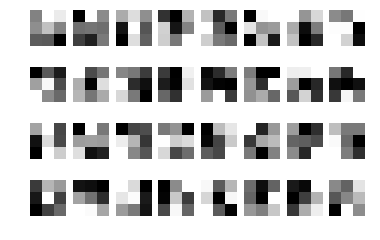

In [16]:
# Weights for the first convolutional layer
w0=model.get_weights()[0][:,:,0,:]

# Normalize to range 0.0 - 1.0
w0-=np.min(w0)
w0/=np.max(w0)

for r in range(4):
    for c in range(8):
        n=r*8+c
        plt.subplot(4, 8, n+1)
        plt.imshow(w0[:,:,n], interpolation='none')
        plt.axis('off')
        plt.gray()
plt.show()

They might be a bit hard to interpret, but it seems they have learned to detect various corners and edges.

## Exercise 3.2. Make a better CNN (4 points)

Make a network that performs better than the very simple one above. For your convenience we have copied the essential code from the previous exercise to the cells below. If you just did the previous exercise you don't need to rerun the first cell.

<span style="background-color: yellow">Your task is to do at least five (5) reparameterizations for the previous exercise's network and compare the results. At least one of them should have a 5% improvement in the test set result (generalization). Each reparameterization should change a different aspect in the network, while the rest of the parameters are the same as in 3.1. Print out all of the plots and results for each setup into the notebook you return, and analyze and discuss the results briefly in the last cell in the bottom.</span>

You probably need to make a few more cells below, and copy-paste the model code (at least five times).

Example parameters to try to change: 

- number of layers or neurons
- activation functions
- epochs
- batch sizes
- optimizer, see [Keras' documentation on optimizers](https://keras.io/optimizers/)
- max-pooling on/off on certain layers

Notice that changing the final layer's softmax activation plus the categorical_crossentropy loss requires some consideration. Don't do it unless you have a good plan.

In [1]:
%matplotlib inline

from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
from keras.layers.convolutional import Conv2D

import exer3_dataset
from keras.utils import np_utils
import matplotlib.pyplot as plt

# Load the dataset
(x_train, y_train), (x_test, y_test) = exer3_dataset.load_data()

# Normalize
x_train = x_train/255
x_test = x_test/255

num_classes = 10

y_train_cat = np_utils.to_categorical(y_train, num_classes)
y_test_cat = np_utils.to_categorical(y_test, num_classes)

Using TensorFlow backend.


4087808/4422102 [==========================>...] - ETA: 0s

MODEL 1

In [52]:
np.random.seed(123)
model = Sequential()

# Add model here
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(28, 28, 1)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Flatten())
model.add(Dense(10,activation='softmax'))

# You can also try different optimizers below
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
flatten_14 (Flatten)         (None, 6400)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                64010     
Total params: 119,754
Trainable params: 119,754
Non-trainable params: 0
_________________________________________________________________
None

In [53]:
%%time

# Training
epochs = 10

history = model.fit(x_train, 
                    y_train_cat, 
                    epochs=epochs, 
                    batch_size=128,
                    verbose=1)

Epoch 1/10
60000/60000 [==============================] - 74s - loss: 0.5087 - acc: 0.8152    
Epoch 2/10
60000/60000 [==============================] - 72s - loss: 0.3106 - acc: 0.8889    
Epoch 3/10
60000/60000 [==============================] - 80s - loss: 0.2573 - acc: 0.9084    
Epoch 4/10
60000/60000 [==============================] - 106s - loss: 0.2242 - acc: 0.9195   
Epoch 5/10
60000/60000 [==============================] - 98s - loss: 0.2004 - acc: 0.9280    
Epoch 6/10
60000/60000 [==============================] - 125s - loss: 0.1811 - acc: 0.9354   
Epoch 7/10
60000/60000 [==============================] - 180s - loss: 0.1638 - acc: 0.9406   
Epoch 8/10
60000/60000 [==============================] - 152s - loss: 0.1466 - acc: 0.9468   
Epoch 9/10
60000/60000 [==============================] - 147s - loss: 0.1288 - acc: 0.9541   
Epoch 10/10
60000/60000 [==============================] - 169s - loss: 0.1165 - acc: 0.9576   
CPU times: user 1h 11min 57s, sys: 7min 18s, tota

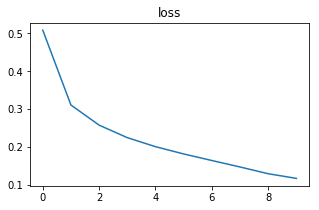

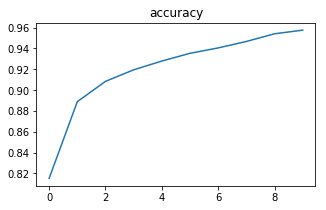

In [54]:
# Plot loss and accuracy in training

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'])
plt.title('accuracy')

In [55]:
# Evaluate on test set
scores = model.evaluate(x_test, y_test_cat, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 92.19%


MODEL 2

In [10]:
np.random.seed(123)
model = Sequential()

# Add model here
model.add(Conv2D(64,(3,3),activation='sigmoid',input_shape=(28, 28, 1)))
model.add(Conv2D(32,(3,3),activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(10,activation='softmax'))

# You can also try different optimizers below
model.compile(loss='categorical_crossentropy', 
              optimizer='sgd', 
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 32)        18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                46090     
Total params: 65,194
Trainable params: 65,194
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
%%time

# Training
epochs = 10

history = model.fit(x_train, 
                    y_train_cat, 
                    epochs=epochs, 
                    batch_size=128,
                    verbose=1)

Epoch 1/10
60000/60000 [==============================] - 76s - loss: 2.3406 - acc: 0.1068    
Epoch 2/10
60000/60000 [==============================] - 86s - loss: 2.1685 - acc: 0.2093    
Epoch 3/10
60000/60000 [==============================] - 89s - loss: 1.1339 - acc: 0.6285    
Epoch 4/10
60000/60000 [==============================] - 77s - loss: 0.7923 - acc: 0.7141    
Epoch 5/10
60000/60000 [==============================] - 93s - loss: 0.7045 - acc: 0.7403    
Epoch 6/10
60000/60000 [==============================] - 81s - loss: 0.6571 - acc: 0.7554    
Epoch 7/10
60000/60000 [==============================] - 105s - loss: 0.6238 - acc: 0.7682   
Epoch 8/10
60000/60000 [==============================] - 115s - loss: 0.6000 - acc: 0.7769   
Epoch 9/10
60000/60000 [==============================] - 76s - loss: 0.5838 - acc: 0.7855    
Epoch 10/10
60000/60000 [==============================] - 75s - loss: 0.5719 - acc: 0.7876    
CPU times: user 1h 10min 59s, sys: 8min 1s, total

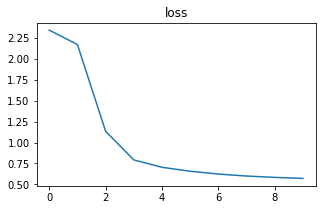

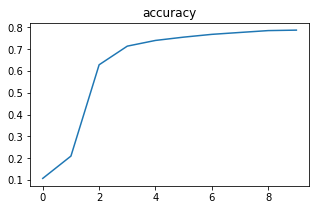

In [12]:
# Plot loss and accuracy in training

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'])
plt.title('accuracy')

In [13]:
# Evaluate on test set
scores = model.evaluate(x_test, y_test_cat, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 77.04%


MODEL 3

In [3]:
np.random.seed(123)
model = Sequential()

# Add model here
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(10,activation='softmax'))

# You can also try different optimizers below
model.compile(loss='categorical_crossentropy', 
              optimizer='sgd', 
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________
None


In [4]:
%%time

# Training
epochs = 15

history = model.fit(x_train, 
                    y_train_cat, 
                    epochs=epochs, 
                    batch_size=128,
                    verbose=1)

Epoch 1/15
60000/60000 [==============================] - 12s - loss: 1.0383 - acc: 0.6646    
Epoch 2/15
60000/60000 [==============================] - 11s - loss: 0.6085 - acc: 0.7872    
Epoch 3/15
60000/60000 [==============================] - 11s - loss: 0.5487 - acc: 0.8053    
Epoch 4/15
60000/60000 [==============================] - 11s - loss: 0.5246 - acc: 0.8128    
Epoch 5/15
60000/60000 [==============================] - 11s - loss: 0.5018 - acc: 0.8233    
Epoch 6/15
60000/60000 [==============================] - 12s - loss: 0.4889 - acc: 0.8274    
Epoch 7/15
60000/60000 [==============================] - 11s - loss: 0.4772 - acc: 0.8316    
Epoch 8/15
60000/60000 [==============================] - 11s - loss: 0.4643 - acc: 0.8369    
Epoch 9/15
60000/60000 [==============================] - 11s - loss: 0.4566 - acc: 0.8384    
Epoch 10/15
60000/60000 [==============================] - 11s - loss: 0.4495 - acc: 0.8435    
Epoch 11/15
60000/60000 [========================

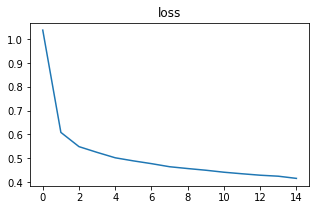

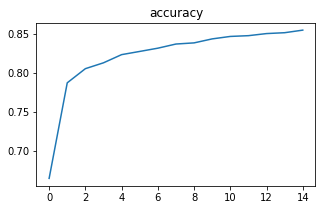

In [5]:
# Plot loss and accuracy in training

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'])
plt.title('accuracy')

In [6]:
# Evaluate on test set
scores = model.evaluate(x_test, y_test_cat, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 84.53%


MODEL 4

In [7]:
np.random.seed(123)
model = Sequential()

# Add model here
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(10,activation='softmax'))

# You can also try different optimizers below
model.compile(loss='categorical_crossentropy', 
              optimizer='adagrad', 
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
%%time

# Training
epochs = 10

history = model.fit(x_train, 
                    y_train_cat, 
                    epochs=epochs, 
                    batch_size=128,
                    verbose=1)

Epoch 1/10
60000/60000 [==============================] - 11s - loss: 0.4823 - acc: 0.8332    
Epoch 2/10
60000/60000 [==============================] - 11s - loss: 0.3657 - acc: 0.8736    
Epoch 3/10
60000/60000 [==============================] - 10s - loss: 0.3386 - acc: 0.8828    
Epoch 4/10
60000/60000 [==============================] - 11s - loss: 0.3238 - acc: 0.8879    
Epoch 5/10
60000/60000 [==============================] - 10s - loss: 0.3127 - acc: 0.8923    
Epoch 6/10
60000/60000 [==============================] - 11s - loss: 0.3043 - acc: 0.8954    
Epoch 7/10
60000/60000 [==============================] - 10s - loss: 0.2977 - acc: 0.8975    
Epoch 8/10
60000/60000 [==============================] - 11s - loss: 0.2921 - acc: 0.8994    
Epoch 9/10
60000/60000 [==============================] - 11s - loss: 0.2875 - acc: 0.9002    
Epoch 10/10
60000/60000 [==============================] - 11s - loss: 0.2834 - acc: 0.9017    
CPU times: user 6min 27s, sys: 1min 44s, total: 8

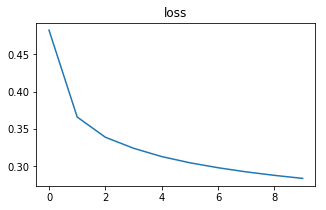

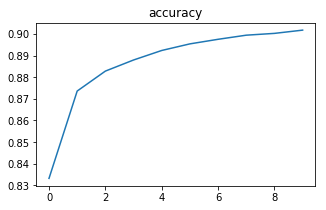

In [9]:
# Plot loss and accuracy in training

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'])
plt.title('accuracy')

In [10]:
# Evaluate on test set
scores = model.evaluate(x_test, y_test_cat, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 88.61%


MODEL 5

In [11]:
np.random.seed(123)
model = Sequential()

# Add model here
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(10,activation='softmax'))

# You can also try different optimizers below
model.compile(loss='categorical_crossentropy', 
              optimizer='sgd', 
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
%%time

# Training
epochs = 10

history = model.fit(x_train, 
                    y_train_cat, 
                    epochs=epochs, 
                    batch_size=64,
                    verbose=1)

Epoch 1/10
60000/60000 [==============================] - 14s - loss: 0.8340 - acc: 0.7167    
Epoch 2/10
60000/60000 [==============================] - 13s - loss: 0.6183 - acc: 0.7878    
Epoch 3/10
60000/60000 [==============================] - 13s - loss: 1.1143 - acc: 0.7679    
Epoch 4/10
60000/60000 [==============================] - 14s - loss: 1.9716 - acc: 0.7558    
Epoch 5/10
60000/60000 [==============================] - 14s - loss: 2.2908 - acc: 0.7613    
Epoch 6/10
60000/60000 [==============================] - 13s - loss: 2.3594 - acc: 0.7723    
Epoch 7/10
60000/60000 [==============================] - 13s - loss: 2.3987 - acc: 0.7847    
Epoch 8/10
60000/60000 [==============================] - 13s - loss: 2.4378 - acc: 0.7923    
Epoch 9/10
60000/60000 [==============================] - 13s - loss: 2.5506 - acc: 0.7930    
Epoch 10/10
60000/60000 [==============================] - 13s - loss: 2.5570 - acc: 0.7995    
CPU times: user 6min 56s, sys: 2min 14s, total: 9

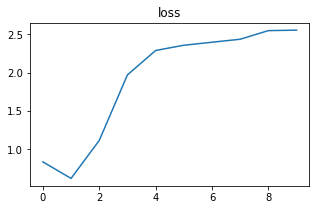

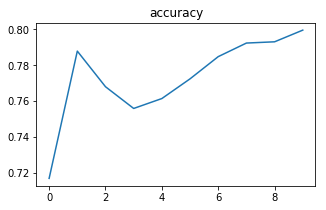

In [13]:
# Plot loss and accuracy in training

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'])
plt.title('accuracy')

In [14]:
# Evaluate on test set
scores = model.evaluate(x_test, y_test_cat, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 81.72%


Adding more neurons and layers helped slightly but not enough to improve 5%. The largest contribution for improvement was to choose other optimizers different to sgd, like adagrad and adam. It makes sense, since an optimizer's aim is to reduce the loss function as more and fast as possible. Therefore adagrad and adam must have faster improvement of the loss. Pooling didn't improve as much the accuracy but it did reduce the processing time. This also makes sense since we're reducing the input of the next layers, so they don't need to process as much as the layers without pooling.